In [40]:
import lyricsgenius as lg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spotipy
import time

from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

from spotipy.oauth2 import SpotifyClientCredentials
from requests.exceptions import Timeout



In [41]:
# artists = ['Logic', 'Rihanna', 'Frank Sinatra']


# def get_lyrics(arr, k):  # Write lyrics of k songs by each artist in arr
#     c = 0  # Counter
#     for name in arr:
#         try:
#             songs = (genius.search_artist(name, max_songs=k, sort='popularity')).songs
#             s = [song.lyrics for song in songs]
#             print("\n \n   <|endoftext|>   \n \n".join(s))  # Deliminator
#             c += 1
#             print(f"Songs grabbed:{len(s)}")
#         except:  #  Broad catch which will give us the name of artist and song that threw the exception
#             print(f"some exception at {name}: {c}")



In [42]:
all_top_songs = pd.read_excel('data/top_10000_songs_201129.xlsx', index_col=0) 

/Users/sam/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [43]:
year_dis_song = all_top_songs.groupby('Year')['Song'].count()

In [44]:
cur_songs_start = 131
cur_songs_end = 135
current_songs = all_top_songs[cur_songs_start:cur_songs_end]

In [45]:
current_songs

,PLACE,Artist,Song,Year,PLACE08,PLACE11,PLACE13,PLACE14,PLACE15,PLACE17,PLACE18
ID,,,,,,,,,,,
83,132,Underworld,Born Slippy,1995,113.0,155.0,134.0,145.0,112.0,128.0,128.0
1238,133,Jerry Lee Lewis,Great Balls of Fire,1957,125.0,143.0,108.0,134.0,151.0,124.0,124.0
1081,134,Booker T. & The MG's,Green Onions,1962,85.0,101.0,114.0,136.0,137.0,129.0,127.0
2254,135,Yeah Yeah Yeahs,Maps,2003,472.0,141.0,152.0,128.0,165.0,157.0,150.0


In [46]:
all_top_albums = pd.read_excel('data/top_3000_albums_201129.xls', index_col=0) 

In [47]:
year_dis_album = all_top_albums.groupby('Year')['Album'].count()

In [48]:
current_albums = all_top_albums.head(5)

In [49]:
current_albums

,PLACE,Artist,Album,Year,PLACE08,PLACE09,PLACE10,PLACE13,PLACE14,PLACE15,PLACE17,PLACE18
i,,,,,,,,,,,,
62,1.0,The Beach Boys,Pet Sounds,1966,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0
811,2.0,Nirvana,Nevermind,1991,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
63,3.0,The Beatles,Revolver,1966,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0
91,4.0,The Velvet Underground & Nico,The Velvet Underground & Nico,1967,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
211,5.0,Marvin Gaye,What's Going On,1971,8.0,6.0,6.0,6.0,6.0,7.0,6.0,7.0


In [50]:
#Look at distribution of songs/albums over the years

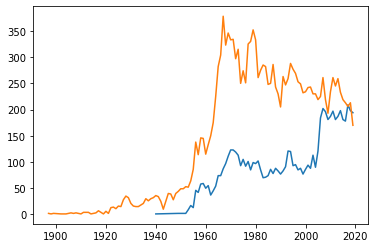

In [51]:
plt.plot(year_dis_album)
plt.plot(year_dis_song)
#orange = songs
#blue = albums

In [52]:
PARENT_GENRES = ["pop", 'rock', 'hip hop', 'latin', 'edm', 'r&b', 
                    'country', 'folk', 'classical', 'metal', 'jazz', 'easy listening', 'new age', 'blues', 'world']
    

In [53]:
def make_dictionaries(parent, fileName):
    assert parent in PARENT_GENRES, "The passed name should be a in PARENT_GENRES"
    
    return_dict = {}
        
    f = open(fileName, "r")
    for line in f:
        if line.strip() != "Explore" and line.strip() !="\n" and line.strip() != "":
      
            child_genre = line.strip().lower()
            return_dict[child_genre] = parent
       
            
    return return_dict

        

In [54]:
pop_dict = make_dictionaries("pop", "./data/pop_children.txt")
rock_dict = make_dictionaries("rock", "./data/rock_children.txt")
hip_hop_dict = make_dictionaries("hip hop", "./data/hip_hop_children.txt")
blues_dict = make_dictionaries("blues", "./data/blues_children.txt")
classical_dict = make_dictionaries("classical", "./data/classical_children.txt")
easy_listening_dict = make_dictionaries("easy listening", "./data/easy_listening_children.txt")
edm_dict = make_dictionaries("edm", "./data/edm_children.txt")
folk_dict = make_dictionaries("folk", "./data/folk_children.txt")
jazz_dict = make_dictionaries("jazz", "./data/jazz_children.txt")
latin_dict = make_dictionaries("latin", "./data/latin_children.txt")
metal_dict = make_dictionaries("metal", "./data/metal_children.txt")
new_age_dict = make_dictionaries("new age", "./data/new_age_children.txt")
r_n_b_dict = make_dictionaries("r&b", "./data/r&b_children.txt")
country_dict = make_dictionaries("country", "./data/country_children.txt")
world_dict = make_dictionaries("world", "./data/world_children.txt")

all_genres_dict = {**pop_dict,**rock_dict, **hip_hop_dict, **blues_dict, **classical_dict, 
                   **easy_listening_dict, **edm_dict, **folk_dict, **jazz_dict, **latin_dict,
                  **metal_dict, **new_age_dict, **r_n_b_dict, **country_dict, **world_dict}

In [35]:
def getArtistGenre(genres):
    '''
    This takes a list of possible genres for an artist from the spotify API
    ex. ['adult standards', 'brill building pop', 'easy listening', 'lounge']
    If a parent genre is in the list it will return that as the genre
    Otherwise it will loop through the genres, and analyze the children genres
    The majority parent genre of the children genre will determine the returned genre
    ex. if 5 of 7 genres parent genre is rock, rock will be returned
    '''
    PARENT_GENRES = ["pop", 'rock', 'hip hop', 'latin', 'edm', 'r&b', 
                    'country', 'folk', 'classical', 'metal', 'jazz', 'easy listening', 'new age', 'blues', 'world']
    
    returnGenre = ""
    
    #First check to see if a parent genre in list of spotify genres
    num_parents_in_genres = 0
    for g in genres:
        if g in PARENT_GENRES:
            returnGenre = g
            num_parents_in_genres+=1
            
    # Edge case two parent genres in a list (['dance pop', 'edm', 'pop', 'pop dance', 'pop rap'])
    # 1: count all of them and return the parent genre with most child genre
    
    if num_parents_in_genres == 1: #If only one parent genre included, return it
        return returnGenre
        
    #If a parent genre didn't show up OR more than one showed up count all genres
    genre_counts = {'pop':0, 
                    'rock':0, 
                    'hip hop':0, 
                    'latin': 0,
                    'edm': 0,
                    'r&b': 0,
                    'country': 0,
                    'folk': 0,
                    'classical': 0,
                    'metal': 0,
                    'jazz': 0,
                    'new age': 0,
                    'blues': 0,
                    'world': 0,
                    'easy listening': 0}
    
    
    for g in genres:
        try:
            parent = all_genres_dict[g]
            genre_counts[parent]+=1
        except:
            pass
        
    #TODO do we need to think about ties?
    max_genre = "no genre"
    max_genre_count = 0
    for p in PARENT_GENRES:
        if genre_counts[p] > max_genre_count:
            max_genre = p
            max_genre_count = genre_counts[p]
            
    returnGenre = max_genre
           
   
    return returnGenre
    
    

In [36]:
def getMostPopWord(lyrics):
    """
    Gets Called in count lyrics
    """

    text_tokens = word_tokenize(lyrics)
    lyrics_without_sw = [word for word in text_tokens if not word in stopwords.words()]
#     print(lyrics_without_sw)
    
    #I tried this. It seems to have some issues. For example, it converts 'us' to 'u'
    #This may not be the best option to get the most common words if the words aren't clearly recognizable
    
#     #Lemmatize the lyrics 
#     lmtzr = WordNetLemmatizer()
#     lem_lyrics = [[lmtzr.lemmatize(word) for word in word_tokenize(s)]
#               for s in lyrics_without_sw]
    
#     lem_lyrics_flat = []
#     for sublist in lem_lyrics:
#         lem_lyrics_flat.extend(sublist)
    
#     print(lem_lyrics_flat)
    
    c = Counter(lyrics_without_sw)
    return c.most_common(5)


def countLyrics(lyrics):
    """
    Takes in the output of 
    "\n \n   <|endoftext|>   \n \n".join([song.lyrics]))
    The first line is always the name of the song and the word lyrics
    There is always a number followed by embed on the last string
    Gets num lyrics, num unique lyrics, and specific word counts
    """
    
    #Remove the first line that has the title of the song and the word 'lyrics'
    split = lyrics.split("\n")
    del split[0]
    lyrics = "\n".join(split)
    
    #Remove the intEMBED at the end of the last string
    split = lyrics.split()
    split[-1] = re.split('\d+', split[-1])[0]
    lyrics = " ".join(split)
    
    #TODO
    """
    Some songs have things like '*background chatter*' in the lyrics 
    we need to remove everything that comes between **
    """
    
    #Convert to lower and remove non-alphnumeric chars
    lyrics = lyrics.lower()
    lyrics = re.sub(r'\W+', ' ', lyrics)   
    most_common_words = getMostPopWord(lyrics)
    
        
    #Parse most common words
    #get most common words (cw) and common word counts (cwc)
    cw1 = most_common_words[0][0]
    cw1c = most_common_words[0][1]
    
    cw2 = most_common_words[1][0]
    cw2c = most_common_words[1][1]
    
    cw3 = most_common_words[2][0]
    cw3c = most_common_words[2][1]
    
    cw4 = most_common_words[3][0]
    cw4c = most_common_words[3][1]
    
    cw5 = most_common_words[4][0]
    cw5c = most_common_words[4][1]


    #Count number of total lyrics and unique lyrics
    allWords = lyrics.split()
    num_unique = len(np.unique(allWords))
    total_words = len(allWords)
    

    #pattern matching
    
    #***************
    # LOVE
    #***************
    love_pattern = 'lov(e|ing|er|es|ely|ed)\s+'
    love_words = len(re.findall(love_pattern, lyrics))
    
    #***************
    # GOD
    #***************
    god_pattern = 'go(d|ds|ddes)\s+|jesus'
    god_words = len(re.findall(god_pattern, lyrics))
    
    #***************
    # DANCE
    #***************
    dance_pattern = 'danc(e|es|ing|er)\s+'
    dance_words = len(re.findall(dance_pattern, lyrics))
    
    #***************
    # COOL
    #***************
    cool_pattern = 'coo(l|ler|lest)\s+'
    cool_words = len(re.findall(cool_pattern, lyrics))
    
    #***************
    # ROCK
    #***************
    rock_pattern = 'roc(k|ked|kers|ks|ker|king)\s+'
    rock_words = len(re.findall(rock_pattern, lyrics))
    
    #***************
    # SWEAR
    #***************
    swear_pattern = 'dam(n|ns|ned)\s+|fuc(k|ks|ked|ker|kers|king)\s+|shi(t|ty|ts|ting|ter)\s+|hel(l|ls)\s+|bitc(h|hes)\s+|bastar(d|ds)|as(s|es)\s+'
    swear_words = len(re.findall(swear_pattern, lyrics))
    
    #***************
    # FAMILY
    #***************
    family_pattern = 'fa(m|mily|milies|)\s+|br(o|other|others)\s+|sis(ter|ters)\s+|so(n|ns)\s+|daugh(ter|ters)\s+|husban(d|ds)|wi(fe|ves)\s+|cousi(n|ns)\s+|uncl(e|es)\s+|aun(t|ts|ties)\s+'
    family_words = len(re.findall(family_pattern, lyrics))
    
    #***************
    # BABY
    #***************
    baby_pattern = 'ba(e|be|baby|babies)\s+'
    baby_words = len(re.findall(baby_pattern, lyrics))
    
    #***************
    # MONEY
    #***************
    money_pattern = 'money\s+|cash\s+|doll(er|ers|a|az)\s+|buc(k|ks)\s+|coi(n|ns)\s+|bil(l|ls|lz)\s+'
    money_words = len(re.findall(money_pattern, lyrics))
    
    #***************
    # FUNKY
    #***************
    funky_pattern = 'fun(k|ky)\s+'
    funky_words = len(re.findall(funky_pattern, lyrics))
    
    #***************
    # CHILL
    #***************
    chill_pattern = 'chil(l|ls)\s+'
    chill_words = len(re.findall(chill_pattern, lyrics))
    
    
    
    
    
    return num_unique, total_words, love_words, god_words, dance_words, cool_words, rock_words, swear_words,cw1,cw1c,cw2,cw2c,cw3,cw3c,cw4,cw4c,cw5,cw5c
    
    
    

In [37]:
#Set up genius API
genius = lg.Genius('cPaJbcaz-llZE_G6jO_bHtcPFyJps_aiwumM5pF_xoPIBkmXHifU6lhHcOcbwOlY',  # Client access token from Genius Client API page
                             skip_non_songs=True, excluded_terms=["(Remix)", "(Live)"],
                             remove_section_headers=True, verbose = False)

genius.sleep_time = 15


In [38]:
#Set up spotify API
cid = '2d2d4ac665f543db93244d6799fc01bc'
secret = '43cd8ad30758405fa3291b1b45e944fd'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [39]:
song_num=0
csv_name = "songs_"+str(cur_songs_start)+ "_"+ str(cur_songs_end)+ ".csv"
csv_fail_name = "songs_"+str(cur_songs_start)+ "_"+ str(cur_songs_end)+ "_fail.csv"

#csv of failed songs
l = open("./input_data/"+csv_fail_name, "w+")
header = "song,artist,year,id,reasonFail\n"
l.write(header)

#csv of completed songs
f = open("./input_data/"+csv_name, "w+")
header = "song|artist|year|genre|numUnique|totalWords|love_words|god_words|dance_words|cool_words|rock_words|swear_words|cw1|cwc1|cw2|cwc2|cw3|cwc3|cw4|cwc4|cw5|cwc5\n"
f.write(header)

#Write a row for each song 
for index, row in current_songs.iterrows():
    
    song_num+=1
    cur_artist = row['Artist']
    cur_song = row['Song']
    cur_year = row['Year']
    cur_id = index
    print(f"iter: {song_num}\nsong: {cur_song}\nartist: {cur_artist}\n______________")


    
    #Genius api
    #Get num word, num unique, specific word counts etc.
    retries = 0
    while retries < 3:
        try:
            #Use genius API 
            song = genius.search_song(cur_song, cur_artist)
            curLyrics = "\n \n   <|endoftext|>   \n \n".join([song.lyrics])
             
            num_unique,total_words,love_words,god_words,dance_words,cool_words,rock_words,swear_words,cw1,cwc1,cw2,cwc2,cw3,cwc3,cw4,cwc4,cw5,cwc5= countLyrics(curLyrics)

            #Spotify api
            #Get Genre
            results = sp.search(q=cur_artist, type='artist')
            items = results['artists']['items']
            if len(items) > 0:
                cur_artist_genre = getArtistGenre(items[0]['genres'])
            else:
                cur_artist_genre = "no genre"
                
                
            #If everything works. Write the line to the file
            line = f"{cur_song}|{cur_artist}|{cur_year}|{cur_artist_genre}|{num_unique}|{total_words}|{love_words}|{god_words}|{dance_words}|{cool_words}|{rock_words}|{swear_words}|{cw1}|{cwc1}|{cw2}|{cwc2}|{cw3}|{cwc3}|{cw4}|{cwc4}|{cw5}|{cwc5}\n"
            f.write(line)
            
        except Timeout as e:
            retries += 1
            continue
            
        except AttributeError as ae: #If we can't find the song, keep track of that song/artist/id
            line = f"{cur_song}|{cur_artist}|{cur_year}|{cur_id}|not_found\n"
            l.write(line)
            


            
        break
        
    if retries == 3: #If we time out 3 times, keep track and move on
        line = f"{cur_song}|{cur_artist}|{cur_year}|{cur_id}|time_out\n"
        l.write(line)
        
f.close()
l.close()



iter: 1
song: Born Slippy
artist: Underworld
______________
iter: 2
song: Great Balls of Fire
artist: Jerry Lee Lewis
______________
iter: 3
song: Green Onions
artist: Booker T. & The MG's
______________
iter: 4
song: Maps
artist: Yeah Yeah Yeahs
______________
